In [1]:
!nvidia-smi

Fri Jan  6 10:48:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    41W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
import os
os.getcwd()

'/home/centos/psw/KSRC'

In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

In [5]:

# 데이콘 데이터셋
train = pd.read_csv('data/train_data.csv', encoding='utf-8')
test = pd.read_csv('data/test_data.csv', encoding='utf-8')

# 카카오 데이터셋
kakao_snli = pd.read_csv('data/snli_1.0_train.ko.tsv', sep='\t', encoding='utf-8')
kakao_snli = kakao_snli[:100000]
kakao_dev = pd.read_csv('data/xnli.dev.ko.tsv', sep='\t', encoding='utf-8')
kakao_test = pd.read_csv('data/xnli.test.ko.tsv', sep='\t', encoding='utf-8')
kakao_dev = pd.concat([kakao_dev,kakao_test, kakao_snli])
kakao_dev.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)

# KLUE 데이터셋
klue_dev = pd.read_json('data/klue-nli-v1.1_dev.json')
klue_dev = klue_dev[['premise', 'hypothesis', 'gold_label']]
klue_train = pd.read_json('data/klue-nli-v1.1_train.json')
klue_train = klue_train[['premise', 'hypothesis', 'gold_label']]
klue_dev = pd.concat([klue_dev,klue_train])
klue_dev.rename(columns = {'gold_label':'label'}, inplace=True)

# 데이콘, 카카오, KLUE 데이터셋 병합
train = pd.concat([train, klue_dev, kakao_dev], axis=0)
train = train.reset_index(drop=True)
train['index'] = train.index
train = train.dropna()
drop_list = list(train.premise.str.len().sort_values().tail(26).index)
train = train.drop(drop_list,axis=0)
train = train.reset_index(drop=True)
train['index'] = train.index
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
159486,159486,같은 방향으로 보이는 숲이 우거진 지역에 의상을 입은 사람들이 모여 있다.,사람들은 의상을 입는다,entailment
159487,159487,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,하이힐을 신은 남자,contradiction
159488,159488,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,서 있는 소녀,entailment
159489,159489,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,사진 촬영 준비를 하고 있는 소녀,neutral


In [6]:
# 결측치는 없음

print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159491 entries, 0 to 159490
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       159491 non-null  int64 
 1   premise     159491 non-null  object
 2   hypothesis  159491 non-null  object
 3   label       159491 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [6]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')

Train Label: 
entailment       53629
contradiction    53486
neutral          52402
Name: label, dtype: int64



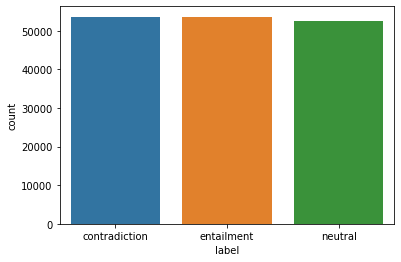

In [7]:
# data imbalance는 사실상 존재하지 않음 

sns.countplot(data=train,x='label');

In [8]:
max_premise = np.max(train['premise'].str.len())

max_hypothesis = np.max(train['hypothesis'].str.len())

In [9]:
print('max premise =',max_premise,"\nmax hypothesis =",max_hypothesis)

max premise = 5610 
max hypothesis = 104


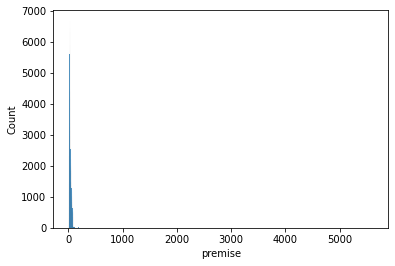

In [10]:
sns.histplot(x=train['premise'].str.len());

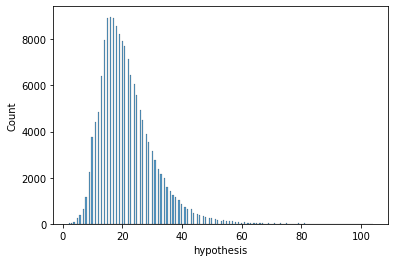

In [11]:
sns.histplot(x=train['hypothesis'].str.len());

In [7]:
# 불 용어 처리 

train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [8]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


In [9]:
def seed_everything(seed:int = 2023):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'class

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [11]:
# train test split 및 tokenizing 
# token에 들어가는 문장은 premise와 hypothesis를 concat 한 문장

train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    0,  3893,  4421,  2043, 10212,  3771,  1164,  2776,  1376,  2250,
         6047,  2299,     2,  4421,  2043, 10212,  2259,  3771,  2138,  1164,
         1567,  5322,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])
[CLS] 역시 이동진 평론가 영화 볼줄 아신다니까 [SEP] 이동진 평론가는 영화를 볼 줄 모른다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [12]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [13]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [14]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(19997))
print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))

127592
{'input_ids': tensor([    0, 20442,  2609,  4415, 28289,  5174,  1116,  3993,  2439,  3664,
         2069,  3894, 19521,  3739, 12293,  3756,  5637,  2200,  6555,  2444,
         7935,  4066,  2290,  2425,  3720,  6509,  7615,  4538,     2, 20442,
         2609,  4415, 28289,  5174,  1116,  3993,  2439,  3664,  2073,  3894,
         2496,  2118,  1380,  2259,  2062,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = pred.predictions
    
    acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

    return {'accuracy': acc,}

In [16]:
training_ars = TrainingArguments(
    output_dir='result/kakao_klue_roberta_clean/',
    num_train_epochs=7,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
trainer.train()
model.save_pretrained('/result/kakao_klue_roberta_clean/best_model')

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 127592
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 13958
  Number of trainable parameters = 336659459
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sangmi. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
500,1.113100,1.100653,0.336186
1000,1.105600,1.104099,0.336186


***** Running Evaluation *****
  Num examples = 31899
  Batch size = 16
Saving model checkpoint to result/kakao_klue_roberta_clean/checkpoint-500
Configuration saved in result/kakao_klue_roberta_clean/checkpoint-500/config.json
Model weights saved in result/kakao_klue_roberta_clean/checkpoint-500/pytorch_model.bin
tokenizer config file saved in result/kakao_klue_roberta_clean/checkpoint-500/tokenizer_config.json
Special tokens file saved in result/kakao_klue_roberta_clean/checkpoint-500/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 31899
  Batch size = 16
Saving model checkpoint to result/kakao_klue_roberta_clean/checkpoint-1000
Configuration saved in result/kakao_kl

In [50]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = 'result/kakao_klue_roberta_clean/best_model'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

loading file vocab.txt from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/vocab.txt
loading file tokenizer.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer_config.json
loading configuration file result/Roberta_Large_Concat/checkpoint-3000/config.json
Model config RobertaConfig {
  "_name_or_path": "result/Roberta_Large_Concat/checkpoint-3000",
  "architectures": [
    "RobertaForSequenceClassification"
  

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [51]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

1666
{'input_ids': tensor([    0,   720,  3994,  2052, 10428,  2775,   647,  3657,  2119,  1085,
            3,     2,   720,  3994,  2052,   911,  2075,  3669,  2119,  3926,
         2088,  1513,  2359, 13964,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [52]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:07<00:00, 14.85it/s]

[1, 2, 0, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 

In [53]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'contradiction'], [1, 'neutral'], [2, 'entailment'], [3, 'contradiction'], [4, 'contradiction'], [5, 'neutral'], [6, 'neutral'], [7, 'contradiction'], [8, 'entailment'], [9, 'neutral'], [10, 'contradiction'], [11, 'entailment'], [12, 'contradiction'], [13, 'entailment'], [14, 'neutral'], [15, 'neutral'], [16, 'contradiction'], [17, 'neutral'], [18, 'contradiction'], [19, 'neutral'], [20, 'contradiction'], [21, 'neutral'], [22, 'neutral'], [23, 'entailment'], [24, 'contradiction'], [25, 'contradiction'], [26, 'entailment'], [27, 'entailment'], [28, 'entailment'], [29, 'entailment'], [30, 'contradiction'], [31, 'contradiction'], [32, 'contradiction'], [33, 'contradiction'], [34, 'neutral'], [35, 'contradiction'], [36, 'contradiction'], [37, 'contradiction'], [38, 'entailment'], [39, 'contradiction'], [40, 'neutral'], [41, 'entailment'], [42, 'entailment'], [43, 'neutral'], [44, 'neutral'], [45, 'contradiction'], [46, 'neutral'], [47, 'entailment'], [48, 'contradiction'], [49, 'entai

In [54]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('roberta_large_submission.csv', index=False)

print(df)

      index          label
0         0  contradiction
1         1        neutral
2         2     entailment
3         3  contradiction
4         4  contradiction
...     ...            ...
1661   1661        neutral
1662   1662     entailment
1663   1663        neutral
1664   1664        neutral
1665   1665        neutral

[1666 rows x 2 columns]


In [7]:
# dpath = '/content/drive/My Drive/Seculayer/KSRC/'
train = pd.read_csv('data/train_data.csv',encoding='utf-8')
test = pd.read_csv('data/test_data.csv',encoding='utf-8')
eval_klue = pd.read_json("data/klue-nli-v1.1_dev.json")
train_klue = pd.read_json("data/klue-nli-v1.1_train.json")
kakao_dev = pd.read_csv('data/xnli.dev.ko.tsv')
kakao_train = pd.read_csv('data/snli_1.0_train.ko.tsv')
kakao_test = pd.read_csv('data/xnli.test.ko.tsv')
train.head()

ParserError: Error tokenizing data. C error: Expected 3 fields in line 17, saw 4
